In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


In [2]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


In [3]:
display(rating.describe())

,userId,productId,rating
count,7.202839e+06,7.202921e+06,7.202920e+06
mean,3.368837e+05,2.651382e+05,4.277313e+00
std,3.619076e+05,1.525959e+05,1.060728e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331870e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965950e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


In [4]:
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [5]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

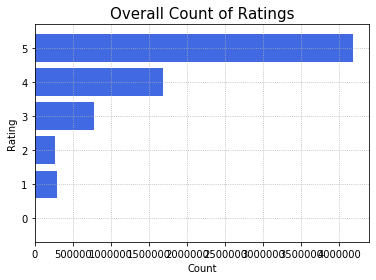

,rating,Count
0,0.0,1
1,1.0,293748
2,2.0,261960
3,3.0,781982
4,4.0,1680574


In [6]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()
display(ratingViaUserCount.head())

In [7]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 50 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 100 ].index)]
print(ratingFiltered.shape)

(1847803, 3)
(7202921, 3)
(35024, 3)


In [8]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratingFiltered[['userId', 'productId', 'rating']], reader)

In [9]:
display(products.sample(10))
display(ratingFiltered.sample(10))
display(ratingFiltered.shape)

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
174997,新概念英语课堂笔记(第4册),"832,1101,921",832,图书音像,1101,少儿/教育图书,921.0,外语
176269,新编矿业工程概论,"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试
381027,Java程序设计实例教程,"832,1096,43",832,图书音像,1096,科技类图书,43.0,计算机/网络
371144,Netcore 磊科 300M高覆盖 全高清无线路由器NW714,"1057,390,815",1057,电脑/办公,390,网络设备,815.0,路由器/中继器
11905,经理人财务管理:如何创造价值(第3版),"832,151,211",832,图书音像,151,经管类图书,211.0,管理
439773,十里春风入酒觞,"832,519,1",832,图书音像,519,文学艺术,1.0,小说
95818,医院质量管理:制度与规程,"832,723,221",832,图书音像,723,人文社科类图书,221.0,政治/军事
312840,高等院校艺术与设计规划教材????数字媒体艺术????中文版Photoshop CS4服装设...,"832,1096,43",832,图书音像,1096,科技类图书,43.0,计算机/网络
186733,折纸大王:交通工具,"832,665,170",832,图书音像,665,生活类图书,170.0,手工/DIY


,userId,productId,rating
3656611,47093.0,276437,5.0
6083704,159840.0,501824,4.0
4568289,7621.0,76766,5.0
4023224,23300.0,90897,5.0
6756382,684.0,407907,3.0
4419089,15019.0,11672,1.0
5610862,33200.0,469363,4.0
6937206,208308.0,355360,4.0
3729669,24977.0,282904,4.0
3855831,270.0,55019,5.0


(35024, 3)

In [10]:
print('No. of Unique Users    :', ratingFiltered.userId.nunique())
print('No. of Unique Products :', ratingFiltered.productId.nunique())
print('No. of Unique Ratings  :', ratingFiltered.rating.nunique())
print(products.iloc[1].product_name)

No. of Unique Users    : 241
No. of Unique Products : 22683
No. of Unique Ratings  : 5
Treasure Island


In [11]:
productJoinEdRaiting = pd.merge(products, ratingFiltered, on='productId', how='inner')

In [12]:
display(productJoinEdRaiting.sample(10))

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
8740,132105,滨崎步:私物语 新歌+精选(CD+DVD),"832,552,1035",832,图书音像,552,音像,1035.0,日韩流行,6502.0,4.0
4266,62248,PIGEON贝亲防溢乳垫120片装(塑料袋装)QA23,"911,819,38",911,母婴/玩具,819,孕妇用品,38.0,其它用品,43787.0,5.0
31144,468470,Life Of Pi,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书,953.0,4.0
34874,523215,Disney迪士尼米奇幻影14.1英寸笔记本内胆包-DNC100329-黑,"1057,24,89",1057,电脑/办公,24,笔记本/平板配件,89.0,电脑包,5226.0,4.0
26035,393798,Maybelline 美宝莲水晶胶原唇彩 R22 7ml 新,"916,416,323",916,美妆个护,416,彩妆,323.0,唇彩/唇蜜,5693.0,5.0
27769,419932,邓小平时代,"832,723,221",832,图书音像,723,人文社科类图书,221.0,政治/军事,4251.0,5.0
18972,291560,诺基亚C2-02(NOKIA C2-02) 触键双控手机(黑色),"1128,640,304",1128,手机/数码,640,手机通讯,304.0,手机,2277.0,5.0
18631,286302,建筑师成长记录:学习建筑的101点体会,"832,1096,750",832,图书音像,1096,科技类图书,750.0,建筑,3204.0,5.0
3628,51713,PNY 必恩威 迷你 mini M1 8G 优盘,"1057,268,378",1057,电脑/办公,268,存储设备,378.0,U盘,20103.0,5.0
1895,25140,Nautica 诺帝卡 男式 羽绒马甲 J14302,"802,799,1082",802,服饰服装,799,男装,1082.0,羽绒服,193293.0,5.0


In [13]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    # 首先将预测值映射至每个用户
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [17]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

56597.0 [172401, 347091, 383875, 343721, 116365, 523899, 408988, 63040, 18334, 179815]
56918.0 [423881, 145678, 87556, 344473, 275707, 36768, 427323, 163755, 91336, 319646]
47.0 [506610, 50060, 111738, 464114, 113408, 295333, 379443, 317452, 77802, 489369]
24590.0 [224293, 224940, 275707, 407618, 408988, 258451, 108164, 148015, 462270, 343224]
103250.0 [457976, 459600, 460034, 460036, 460167, 460902, 303194, 233183, 238263, 242688]
5729.0 [458066, 305512, 309994, 46066, 375249, 105800, 424508, 434210, 335944, 147296]
10712.0 [224293, 8874, 289752, 317452, 203606, 406937, 206404, 399819, 248255, 322714]
79411.0 [457087, 303194, 370619, 375073, 337154, 343930, 227396, 157009, 210679, 213744]
391.0 [105523, 575, 206404, 421869, 473113, 273771, 151014, 427323, 373667, 224293]
953.0 [47262, 487555, 263995, 321281, 182366, 303194, 383297, 4357, 503913, 475351]
18235.0 [373834, 311095, 320158, 159930, 479700, 93652, 518304, 467383, 196081, 97355]
66003.0 [479010, 145678, 303194, 44574, 1347, 

In [25]:
# print(type(testset))
# print(type(testset[0]))
# dt=np.dtype('int,int,float')
# xarr = np.array(testset)
# print(xarr[:,2].max())
# print(xarr[:,2].min())
# print(xarr[:,2][0])
# xarr[:,2]
# display(testset)
temp = ratingFiltered[ratingFiltered.userId == 56592 ]
display(temp.head())
temp = temp[temp.productId == 453451]
display(temp)
testset = trainset.build_anti_testset()
display(testset)

,userId,productId,rating


,userId,productId,rating


[(56597.0, 452640, 4.302621059844678),
 (56597.0, 452658, 4.302621059844678),
 (56597.0, 452679, 4.302621059844678),
 (56597.0, 452708, 4.302621059844678),
 (56597.0, 452781, 4.302621059844678),
 (56597.0, 452809, 4.302621059844678),
 (56597.0, 452831, 4.302621059844678),
 (56597.0, 452860, 4.302621059844678),
 (56597.0, 452919, 4.302621059844678),
 (56597.0, 452928, 4.302621059844678),
 (56597.0, 452966, 4.302621059844678),
 (56597.0, 452982, 4.302621059844678),
 (56597.0, 452990, 4.302621059844678),
 (56597.0, 453007, 4.302621059844678),
 (56597.0, 453067, 4.302621059844678),
 (56597.0, 453071, 4.302621059844678),
 (56597.0, 453091, 4.302621059844678),
 (56597.0, 453096, 4.302621059844678),
 (56597.0, 453104, 4.302621059844678),
 (56597.0, 453134, 4.302621059844678),
 (56597.0, 453155, 4.302621059844678),
 (56597.0, 453172, 4.302621059844678),
 (56597.0, 453206, 4.302621059844678),
 (56597.0, 453208, 4.302621059844678),
 (56597.0, 453231, 4.302621059844678),
 (56597.0, 453275, 4.3026

In [44]:
from numpy import *
from numpy import random
import matplotlib.pyplot as plt



ratingFiltered2 = ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' )
raitingFilteredPivot = ratingFiltered2.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

rating_matrix = raitingFilteredPivot
rating_matrix = rating_matrix.to_numpy()
user_num = rating_matrix.shape[0]
item_num = rating_matrix.shape[1]

# initialize user and item matrix with random float between -1 and 1(not included)
feature_num = 2
user_matrix = random.random_sample((user_num, feature_num))
item_matrix = random.random_sample((item_num, feature_num))


def sgd(data_matrix, user, item, alpha, lam, iter_num):
    display(data_matrix)
    for j in range(iter_num):
#         data_matrix.loc[]
        for u in range(data_matrix.shape[0]):
            for i in range(data_matrix.shape[1]):
                if data_matrix[u,i] != 0:
                    e_ui = data_matrix[u,i] - sum(user[u,:] * item[i,:])
                    user[u,:] += alpha * (e_ui * item[i,:] - lam * user[u,:])
                    item[i,:] += alpha * (e_ui * user[u,:] - lam * item[i,:])
    return user, item

user, item = sgd(rating_matrix, user_matrix, item_matrix, 0.001, 0.1, 200)
filter_matrix_entry = rating_matrix <= 0
matrix_predict = dot(user, item.transpose())

# filter the ratings that are already rated
matrix_predict_filtered = matrix_predict * filter_matrix_entry
# save matrix_predict and matrix_predict_filtered to the files respectively
# and make every element correct to two decimal places
savetxt('matrix_predict.txt', matrix_predict, fmt='%.2f')
savetxt('matrix_predict_filtered.txt', matrix_predict_filtered, fmt='%.2f')

# MF for new comer
# randomly initialize the new comer's rate
new_comer_Eric = random.randint(0, 6, size=100)
rating_matrix_new = vstack((rating_matrix, new_comer_Eric))
user_matrix_new = 2 * random.random_sample((user_num+1, feature_num)) - 1
item_matrix_new = 2 * random.random_sample((item_num, feature_num)) - 1
user_new, item_new = sgd(rating_matrix_new, user_matrix_new, item_matrix_new, 0.01, 0.1, 100)
print('The latent feature of new comer(user) is : ', user_new[-1, :])


# let us put bias into the model
# get the overall average rating
def get_miu(data_matrix):

    non_zero_num = 0
    non_zero_sum = 0
    for i in range(data_matrix.shape[0]):
        for j in range(data_matrix.shape[1]):
            if data_matrix[i][j] != 0:
                non_zero_num += 1
                non_zero_sum += data_matrix[i][j]
    return non_zero_sum/non_zero_num, non_zero_num


# the sgd funtion with bias, note that bu and bi shoulde also be trained!(very important)
def sgd_bias(data_matrix, user, item, alpha, lam, iter_num, miu):

    b_u = [1] * rating_matrix.shape[0]
    b_i = [1] * rating_matrix.shape[1]
    for j in range(iter_num):
        for u in range(data_matrix.shape[0]):
            for i in range(data_matrix.shape[1]):
                if data_matrix[u][i] != 0:
                    b_ui = b_u[u] + b_i[i] + miu
                    e_ui = data_matrix[u][i] - b_ui - sum(user[u,:] * item[i,:])
                    user[u,:] += alpha * (e_ui * item[i,:] - lam * user[u,:])
                    item[i,:] += alpha * (e_ui * user[u,:] - lam * item[i,:])
                    b_u[u] += alpha * (e_ui - lam * b_u[u])
                    b_i[i] += alpha * (e_ui - lam * b_i[i])
    return user, item, b_u, b_i

miu, non_zero_num = get_miu(rating_matrix)
print(miu, non_zero_num)
print('the sparse rate of rating matrix is : %.3f' % (non_zero_num/2500))


user_bias, item_bias, b_u, b_i = sgd_bias(rating_matrix, user_matrix, item_matrix, 0.001, 0.1, 1000, miu)
print(user_bias)

# visualize user and item feature
plt.plot(item_bias[:, 0], item_bias[:, 1], 'b*')
plt.plot(user_bias[:, 0], user_bias[:, 1], 'yo')
plt.show()

# calculate MSE
def cal_MSE(data_matrix, predict_matrix, non_zero_num):
    filter_matrix_entry = data_matrix > 0
    predict_matrix_filtered = predict_matrix * filter_matrix_entry
    diff_matrix = (predict_matrix_filtered - data_matrix) * (predict_matrix_filtered - data_matrix)
    mse = (1/non_zero_num) * (diff_matrix.sum())
    return mse

# get the right predictive matrix with bias
matrix_predict_bias = dot(user_bias, item_bias.transpose())
for u in range(matrix_predict_bias.shape[0]):
    for i in range(matrix_predict_bias.shape[1]):
        matrix_predict_bias[u][i] += (miu + b_u[u] + b_i[i])

print(matrix_predict, matrix_predict_bias)
mse = cal_MSE(rating_matrix, matrix_predict, non_zero_num)
mse_bias = cal_MSE(rating_matrix, matrix_predict_bias, non_zero_num)
print('the MSE of the matrix factorization is %.4f' % mse)
print('the MSE of the matrix factorization with considering bias is %.4f' % mse_bias)

array([[5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

KeyboardInterrupt: 

In [43]:
rating_matrix

productId,4,11,24,31,47,54,115,119,176,180,...,525340,525356,525367,525377,525390,525414,525440,525469,525568,525607
userId,,,,,,,,,,,,,,,,,,,,,
47.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
391.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223706.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
import sklearn
from sklearn.decomposition import TruncatedSVD

userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 100 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 150 ].index)]
print(ratingFiltered.shape)


ratingFiltered2 = ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' )
raitingFilteredPivot = ratingFiltered2.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

X = raitingFilteredPivot.values.T
X.shape

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(1334724, 3)
(7202921, 3)
(16028, 3)


(11932, 12)

In [19]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(11932, 11932)

In [21]:
display(corr)

array([[ 1.        , -0.013964  , -0.04012085, ..., -0.00535197,
         0.00748834,  0.25819346],
       [-0.013964  ,  1.        , -0.30863091, ..., -0.13105668,
        -0.54574154,  0.26903053],
       [-0.04012085, -0.30863091,  1.        , ..., -0.15824471,
         0.07146141, -0.18538241],
       ...,
       [-0.00535197, -0.13105668, -0.15824471, ...,  1.        ,
        -0.03194197, -0.1578874 ],
       [ 0.00748834, -0.54574154,  0.07146141, ..., -0.03194197,
         1.        ,  0.18201855],
       [ 0.25819346,  0.26903053, -0.18538241, ..., -0.1578874 ,
         0.18201855,  1.        ]])

In [46]:
display(raitingFilteredPivot.shape)

(56, 11932)

In [36]:
productIds = raitingFilteredPivot.columns
productIdsList = list(productIds)

[47,
 54,
 115,
 119,
 176,
 226,
 280,
 322,
 360,
 391,
 575,
 606,
 615,
 693,
 748,
 858,
 910,
 923,
 953,
 1142,
 1237,
 1300,
 1347,
 1460,
 1469,
 1484,
 1508,
 1521,
 1525,
 1527,
 1601,
 1659,
 1694,
 1763,
 1809,
 1810,
 1859,
 1878,
 1955,
 1973,
 1987,
 2067,
 2097,
 2109,
 2183,
 2262,
 2263,
 2277,
 2281,
 2332,
 2457,
 2467,
 2483,
 2559,
 2583,
 2601,
 2640,
 2681,
 2700,
 2751,
 2764,
 2790,
 2802,
 2853,
 2857,
 2962,
 3060,
 3108,
 3119,
 3121,
 3174,
 3213,
 3225,
 3270,
 3318,
 3324,
 3356,
 3404,
 3528,
 3620,
 3632,
 3785,
 3982,
 4010,
 4051,
 4070,
 4091,
 4095,
 4217,
 4228,
 4234,
 4251,
 4263,
 4329,
 4384,
 4428,
 4595,
 4609,
 4620,
 4624,
 4634,
 4810,
 4835,
 4945,
 5066,
 5200,
 5226,
 5229,
 5268,
 5325,
 5333,
 5363,
 5368,
 5428,
 5467,
 5570,
 5574,
 5596,
 5693,
 5729,
 5843,
 5917,
 5924,
 6031,
 6057,
 6059,
 6116,
 6156,
 6213,
 6267,
 6269,
 6400,
 6423,
 6513,
 6538,
 6611,
 6623,
 6734,
 6755,
 6775,
 6786,
 6797,
 6831,
 6848,
 6881,
 6883,

In [45]:
watchIndex = productIdsList.index(280)
print(products.iloc[280])
corr_coffey_hands  = corr[watchIndex]

# list(productIds[(corr_coffey_hands >= 0.9)])

for i in productIds[(corr_coffey_hands >= 0.9)]:
    print( products.iloc[i].product_name )

# display(productIdsList)
# display(productIdsList[0])

product_name    CASIO 卡西欧 指针Child系列电池防水女表 LQ-139BMV-1B
catIds                                     486,487,706
cat1                                               486
cat1_name                                  钟表/首饰/眼镜/礼品
cat2                                               487
cat2_name                                           钟表
cat3                                               706
cat3_name                                           手表
Name: 280, dtype: object
CASIO 卡西欧 指针Child系列电池防水女表 LQ-139BMV-1B
阳宅三要(套装共3册)
Rapoo 雷柏 3500时尚鹅卵石外形激光鼠标(酷黑)(2.4GHz无线传输技术 USB接口设计 即插即用)
韩国语能力考试语法大纲真题解析和实战训练(中级)
TO-PLAN 日系22055 双层蕾丝立体绣花 两折公主洋伞 黑胶太阳伞 晴雨伞 (银灰)
Mentholatum曼秀雷敦乐肤洁清爽洁面泡沫150ml(特卖)
爱的教育
汪曾祺集:一辈古人
丹杰仕 男士韩版立领格子机车皮衣潮流棉衣棉服 修身款偏小一码813JK201
怒江之战:大结局(赠《听雷》试读本)
Eshow 易秀 【春季新品】 2014新款春季彩色帆布包酷炫休闲女款小挎包BFY000071
动物小说大王沈石溪????品藏书系:第七条猎狗
报海旧闻(修订版)
PARKER派克 卓尔系列纯银格子纹金夹墨水笔(钢笔)(正品行货 品质保证)
MG美即海洋冰泉补水面膜25g*10片(特卖)
Kawasaki 川崎 羽毛球10号(2桶24只装)
Kawasaki 川崎 追风系列 中性 羽毛球鞋 K-001
非常班级系列第1季(套装共6册)
会飞的教室(畅销版)
首信雅器版S718老人手机 (超大按